# ☞ Background and overview #

We'll be learning how to create movies of dynamic brain networks using single-subject and multi-subject fMRI data.  After getting the dataset and wrangling it into the proper format, there are three basic steps:
1. Use (Hierarchical) Topographic Factor Analysis [(H)TFA] to obtain a set of network "hubs," and the moment-by-moment hub activations.  Model details may be found [here](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0094914) and [here](http://www.biorxiv.org/content/early/2017/02/07/106690).  This creates a simplified version of the full-brain data that is especially useful for computing dynamic network patterns.
1. Use the hub activations to approximate the average functional connectivity matrix, and to compute the dynamic connectivity patterns reflected by the data.  To estimate functional connectivity patterns in multi-subject data, we'll be using Inter-Subject Functional Connectivity (ISFC), which you can read more about [here](https://docs.wixstatic.com/ugd/b75639_92eab30b43284ca0bd163e3daa709eda.pdf).
1. Use [nilearn](http://nilearn.github.io/) and [hypertools](http://hypertools.readthedocs.io/en/latest/) to visualize the results and create pretty animations.

## Quick start guide
- One way to go through this tutorial is to start at the top and go through section by section (executing each cell in turn).
- Alternatively, you can skim through the entire notebook and just run or explore the parts you're interested in.
    - Some sections below are marked with a ☞.  The blocks of code following those sections are required to run the main analyses.  Those marked sections are also the ones that contain code you'll need if you want to run larger scale analyses, e.g. outside of this tutorial.
    - Other sections are marked with a ⭑.  These contain suggested "challenge problems" that you can solve to gain further fluency with these approaches.
- A third option is to run all of the code in sequence (Cell > Run All) before starting to read it through.  That will generate all of the figures and give you access to the data and relevant variables, and then you can go back and explore the parts that look interesting.

In [ ]:
!pip install nilearn
!pip install brainiak
!pip install hypertools
!pip uninstall scikit-learn==1.0.1 -y
!pip install scikit-learn>0.24

In [ ]:
#!pip uninstall brainiak -y
!pip --version
!pip install -U setuptools

In [1]:
# Install older version of brainiak
#!wget https://github.com/brainiak/brainiak/archive/refs/tags/v0.6.tar.gz
#!mkdir brainiak_src
#!tar xvf v0.6.tar.gz --directory brainiak_src
!python -m pip install --no-use-pep517 -e ./brainiak_src/brainiak-0.6 #https://github.com/brainiak/brainiak/archive/refs/tags/v0.8.zip 

Obtaining file:///content/brainiak_src/brainiak-0.6
ERROR: Command errored out with exit status 1: python setup.py egg_info Check the logs for full command output.


In [5]:
from brainiak.factoranalysis.tfa import TFA
from brainiak.factoranalysis.htfa import HTFA

import hypertools as hyp
import seaborn as sns
import nilearn.plotting as niplot
import matplotlib as mpl

from nilearn.input_data import NiftiMasker
import nibabel as nib
import numpy as np
import scipy.spatial.distance as sd

import zipfile
import os, sys, glob, warnings
from copy import copy as copy
from mpi4py import MPI
import urllib.request
from multiprocessing import Pool

from IPython.display import YouTubeVideo, HTML

%matplotlib inline

ModuleNotFoundError: ignored

In [54]:
import brainiak
print(brainiak)

<module 'brainiak' from '/usr/local/lib/python3.7/dist-packages/brainiak/__init__.py'>


## Experiment ##
We'll be exploring a part of a dataset collected by Uri Hasson's lab.  The experiment had 36 participants listen *Pie Man*, a story told by Jim O'Grady as part of *The Moth* live storytelling event.  You can listen to the story here:

In [ ]:
YouTubeVideo('3nZzSUDECLo')

## Data ##
The dataset comprises 36 preprocessed .nii files, and may be downloaded [here](http://dataspace.princeton.edu/jspui/handle/88435/dsp015d86p269k).  However, in the interest of running the analyses quickly, for this tutorial we're going to be working with data from just 3 participants (this smaller dataset may be found [here](http://discovery.dartmouth.edu/~jmanning/MIND/pieman_mini/pieman_data2.zip), and will be downloaded in the next cell).

## Other datasets to explore ##
[This repository](http://dataspace.princeton.edu/jspui/handle/88435/dsp0147429c369) has a bunch of interesting fMRI datasets in the same format as the sample dataset we'll explore below.

[This dataset](https://github.com/HaxbyLab/raiders_data) collected by Jim Haxby's lab comprises fMRI data as people watched *Indiana Jones: Raiders of the Lost Ark*.

In [ ]:
#Download the data (takes a few minutes...)

#change these lines if you want to download a different dataset!
source = 'https://dataspace.princeton.edu/bitstream/88435/dsp015d86p269k/4/pieman_archive.tar.gz'
destination = '/pieman_archive/pieman_archive.tar.gz'
data_format = '.tar.gz' #file extension

urllib.request.urlretrieve(source, destination)

In [15]:
#Unzip the data
#zipfile.ZipFile(destination, 'r').extractall()
#!mkdir -p pieman_archive/
#!tar xvf pieman_archive.tar.gz --directory pieman_archive
! mv ./pieman_archive/new_pieman/sub*/func/*.nii ./pieman_archive/


In [28]:
#niifiles = glob.glob(os.path.join(destination[0:-(len(data_format)+1)], '*.nii.gz'))
#niifiles.extend(glob.glob(os.path.join(destination[0:-(len(data_format)+1)], '*.nii')))
niifiles = os.listdir("pieman_archive")
niifiles = ["pieman_archive/"+f for f in niifiles if ".nii" in f]
niifiles

['pieman_archive/sub-75-task-rest1.nii',
 'pieman_archive/sub-7-task-intact1.nii',
 'pieman_archive/sub-11-task-word.nii',
 'pieman_archive/sub-66-task-paragraph.nii',
 'pieman_archive/sub-90-task-rest2.nii',
 'pieman_archive/sub-30-task-intact2.nii',
 'pieman_archive/sub-30-task-word.nii']

In [4]:
!rm -rf /pieman_archive/new_pieman/sub-64

### ☞ Data formatting: .nii --> matrix format ###
To computing HTFA-derived brain networks, we're going to first convert the .nii files into [CMU format](http://www.cs.cmu.edu/afs/cs/project/theo-73/www/science2008/README-data-documentation.txt), inspired by Tom Mitchell's website for his 2008 Science paper on predicting brain responses to common nouns ([link](http://www.cs.cmu.edu/afs/cs/project/theo-73/www/science2008/data.html)).

We'll create a dictionary for each .nii (or .nii.gz) file with two elements:
- `Y`: a number-of-timepoints by number-of-voxels matrix of voxel activations
- `R`: a number-of-voxels by 3 matrix of voxel locations

In [25]:
def nii2cmu(nifti_file, mask_file=None):
    def fullfact(dims):
        '''
        Replicates MATLAB's fullfact function (behaves the same way)
        '''
        vals = np.asmatrix(range(1, dims[0] + 1)).T
        if len(dims) == 1:
            return vals
        else:
            aftervals = np.asmatrix(fullfact(dims[1:]))
            inds = np.asmatrix(np.zeros((np.prod(dims), len(dims))))
            row = 0
            for i in range(aftervals.shape[0]):
                inds[row:(row + len(vals)), 0] = vals
                inds[row:(row + len(vals)), 1:] = np.tile(aftervals[i, :], (len(vals), 1))
                row += len(vals)
            return inds
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        img = nib.load(nifti_file)
        mask = NiftiMasker(mask_strategy='background')
        if mask_file is None:
            mask.fit(nifti_file)
        else:
            mask.fit(mask_file)
    
    hdr = img.header
    S = img.get_sform()
    vox_size = hdr.get_zooms()
    im_size = img.shape
    
    if len(img.shape) > 3:
        N = img.shape[3]
    else:
        N = 1
    
    Y = np.float64(mask.transform(nifti_file)).copy()
    vmask = np.nonzero(np.array(np.reshape(mask.mask_img_.dataobj, (1, np.prod(mask.mask_img_.shape)), order='C')))[1]
    vox_coords = fullfact(img.shape[0:3])[vmask, ::-1]-1
    
    R = np.array(np.dot(vox_coords, S[0:3, 0:3])) + S[:3, 3]
    print("Finished: ",nifti_file)
    return {'Y': Y, 'R': R}

In [ ]:
#mask = niifiles[0] #set to None if you don't want the images to match
mask = None
cmu_data = list(map(lambda n: nii2cmu(n, mask),  niifiles))

In [33]:
print(cmu_data[0]['Y'].T)

[[  24.15727043   24.12286758   24.1968956  ...   24.21273804
    24.21084785   23.78277969]
 [ 773.53796387  772.43640137  774.80688477 ...  775.31414795
   775.25360107  761.54650879]
 [1346.46289062 1344.3996582  1347.69848633 ... 1349.56494141
  1348.94494629 1327.47924805]
 ...
 [ 297.91070557  300.08334351  298.43096924 ...  297.62878418
   298.12265015  298.896698  ]
 [ 513.9887085   516.5737915   513.06384277 ...  509.59133911
   513.30780029  512.97332764]
 [ 306.20492554  307.74493408  305.65390015 ...  303.58520508
   305.79922485  305.59997559]]


## Voxel locations

We can get explore the nitty-gritties of the data by visualizaing the voxel activations and voxel locations.  For example, let's try plotting the voxel locations (`R`) for the first subject:

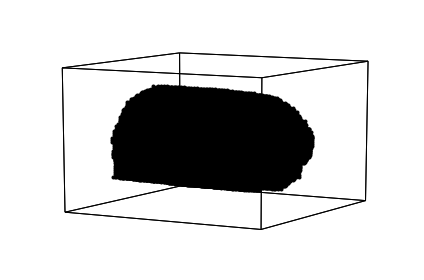

In [30]:
hyp.plot(cmu_data[0]['R'], 'k.');

## Voxel activations

And now let's plot a sample of voxel activations.  For fun, let's plot the first subject's data as a trajectory using HyperTools.  We'll first project the data down to 3 dimensions using mini batch dictionary learning.  HyperTools supports a wide variety of dimensionality reduction algorithms (more info [here](http://hypertools.readthedocs.io/en/latest/hypertools.plot.html#hypertools.plot)).  Try changing the next cell to reduce the data using Fast ICA (`model='FastICA'`) or creating an animation (`animate=True`).

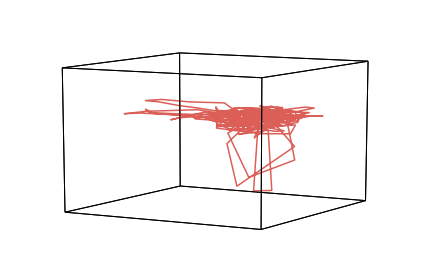

In [38]:
hyp.plot(cmu_data[2]['Y'], model='IncrementalPCA');

## ☞ Converting between (timepoints by voxels) and (voxels by timepoints) data matrices ##

HyperTools and nilearn expect the data matrices to have number-of-timepoints rows and number-of-voxels columns.  BrainIAK expects the data in the transpose of that format-- number-of-voxels by number-of-timepoints matrices.  We can easily convert between the two formats using the `map` function.

In [39]:
htfa_data = list(map(lambda x: {'R': x['R'], 'Z': x['Y'].T}, cmu_data))

# ☞ Using Topographic Factor Analysis to finding network "hubs" in one subject's data #

Applying [Topographic Factor Analysis](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0094914) (TFA) to a single subject's data reveals a set of `K` spherical network hubs that may be used to characterize the data in a highly compact form that is convenient for summarizing network patterns.  Let's apply TFA to one subject's data and plot the resulting network hubs.

In [57]:
nvoxels, ntimepoints = htfa_data[1]['Z'].shape
print(nvoxels, ntimepoints)
K = 10 #number of hubs to find
tfa = TFA(K=K,
          max_num_voxel=int(nvoxels*0.05),    #parameterizes the stochastic sampler (number of voxels to consider in each update); increase for precision, decrease for speed
          max_num_tr = int(ntimepoints*0.1), #parameterizes the stochastic sampler (number of timepoints to consider in each update)
          verbose=False)

tfa.fit(htfa_data[1]['Z'], htfa_data[1]['R'])

91388 300


AttributeError: ignored

TypeError: ignored

In [ ]:
#plot the hubs on a glass brain!
niplot.plot_connectome(np.eye(K), tfa.get_centers(tfa.local_posterior_), node_color='k');

## Compare the original vs. TFA-reduced data trajectories

We'll use HyperTools to project the original data and the TFA-reduced data onto the same 3D space (using t-SNE).

In [ ]:
reduced_raw = hyp.tools.reduce(htfa_data[0]['Z'], ndims=K)
reduced_tfa = tfa.W_.T

hyp.plot([reduced_raw, reduced_tfa], align=True, legend=['Original data', 'TFA-reduced data (K = ' + str(K) + ')'], model='TSNE');

# ☞ Visualizing how the brain images are simplified using TFA

Above, we defined the `nii2cmu` function to convert nii images to CMU-formatted images.  We can also recover nii images from CMU images.  We'll use this to visualize an example volume from the nifti image we just fit TFA to, and we will also visualize the TFA reconstruction to help us understand which aspects of the data TFA is preserving well (or poorly).

In [ ]:
def cmu2nii(Y, R, template):
    Y = np.array(Y, ndmin=2)
    img = nib.load(template)
    S = img.affine
    locs = np.array(np.dot(R - S[:3, 3], np.linalg.inv(S[0:3, 0:3])), dtype='int')
    
    data = np.zeros(tuple(list(img.shape)[0:3]+[Y.shape[0]]))
    
    # loop over data and locations to fill in activations
    for i in range(Y.shape[0]):
        for j in range(R.shape[0]):
            data[locs[j, 0], locs[j, 1], locs[j, 2], i] = Y[i, j]
    
    return nib.Nifti1Image(data, affine=img.affine)

In [ ]:
original_image = cmu2nii(htfa_data[0]['Z'][:, 0].T, htfa_data[0]['R'], niifiles[0])
niplot.plot_glass_brain(original_image, plot_abs=False);

## Reconstructing an image using the fitted TFA posterior

TFA decomposes images into the product of a number-of-timepoints by K "weights" matrix (`tfa.W_.T`) and a K by number-of-voxels "factors" matrix (`tfa.F_.T`).  (Each factor is parameterized by a 3D center and a width parameter, and corresponds to a "hub" somewhere in the brain.)

In [ ]:
tfa_reconstruction = cmu2nii(np.dot(np.array(tfa.W_.T[0, :], ndmin=2), tfa.F_.T), htfa_data[0]['R'], niifiles[0])
niplot.plot_glass_brain(tfa_reconstruction, plot_abs=False);

Interestingly, the factors matrix may be constructed on the fly, and we can use any voxel locations to construct it (even if we did not use those locations to fit the original model).  This is sometimes useful, e.g. in that it provides a natural way of converting between images taken at different resolutions or with different sets of voxels.  Let's try doing this same reconstruction, but for a different set of locations (we'll use the standard 2mm voxel MNI brain locations).  Notice that we don't have to re-fit the model...this remapping to any new coordinate space can be done on the fly once we have the fitted TFA model.

In [ ]:
#download the template brain image
std_source = 'http://discovery.dartmouth.edu/~jmanning/MIND/avg152T1_brain.nii.gz'
std_destination = '/mnt/standard_brain.nii.gz'
urllib.request.urlretrieve(std_source, std_destination)

In [ ]:
#get the voxel locations
std_cmu_img = nii2cmu(std_destination)

#re-compute factor matrix at the new locations
[unique_R, inds] = tfa.get_unique_R(std_cmu_img['R'])
F = tfa.get_factors(unique_R, inds, tfa.get_centers(tfa.local_posterior_), tfa.get_widths(tfa.local_posterior_)).T

#plot the inferred activity at the new locations
tfa_reconstruction2 = cmu2nii(np.dot(tfa.W_.T[0, :], F), std_cmu_img['R'], std_destination)
niplot.plot_glass_brain(tfa_reconstruction2, plot_abs=False);

### Taking a moment to reflect on what we've just done...

It may not look like much, but consider what we've done: we've taken a series of fMRI volumes and inferred a set of "hubs" that those volumes reflect.  Then, using just 4 x K numbers to represent the hub locations and radii, and another K numbers to represent the hub weights for the example image (in this case, a total of K x 5 = 50 numbers) we've already captured a lot of the gross low spatial frequency features of the images!  Further, we only need K=10 additional numbers to represent any new image.  Considering that the original images have 94537 voxels (and therefore 94537 activation values *per image*), that's quite a nice compression ratio!

# Visualizing one person's "connectome" using TFA

The weight matrix (`tfa.W_`) tells us how "active" each network hub is during each timepoint (image) in the dataset.  We can compute the "functional connections" (correlations) between every hub using `sd.pdist`.

In [ ]:
connectome = 1 - sd.squareform(sd.pdist(tfa.W_), 'correlation')
niplot.plot_connectome(connectome, 
                       tfa.get_centers(tfa.local_posterior_), 
                       node_color='k', 
                       edge_threshold='75%');

# ☞ Visualizing one person's "dynamic connectome" using TFA

We can compute the connectome during a limited range of times by computing the correlation matrix only for images collected during that limited time window.  To estimate how the connectome changes over time, we can slide a time window over the range of times in our dataset, and compute a connectome for each sliding window.  We'll create a movie by creating a connectome plot for each frame, and then stitching the frames together.

To help with this process, we'll create two functions:
1. `dynamic_connectome(W, n)`: given a number-of-timepoints by K hub activation matrix (`W`) and a sliding window length (`n`), return a new matrix where each row is the "[squareform](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.squareform.html#scipy.spatial.distance.squareform)" of the connectome during that sliding window.
2. `animate_connectome(hubs, connectomes)`: given a K by 3 "hub coordinates" matrix and the output of `dynamic_connectome`, return an animation object that displays the dynamic connectome.

In [ ]:
def dynamic_connectome(W, n):
    T = W.shape[0]
    K = W.shape[1]
    
    if n <= 0:
        np.array(connectome = 1 - sd.pdist(tfa.W_, 'correlation'), ndmin=2)
    else:
        connectome = np.zeros([T - n + 1, int((K ** 2 - K) / 2)])
        for t in range(T - n + 1):
            connectome[t, :] = 1 - sd.pdist(W[t:(t+n), :].T, 'correlation')
    return connectome

In [ ]:
def animate_connectome(hubs, connectomes, figstr='figs', force_refresh=False):
    
    
    figdir = os.path.join(destination[0:-(len(data_format)+1)], str(np.unique(K)[0]), figstr)
    try:
        os.makedirs(figdir)
    except:
        None
    
    #save a jpg file for each frame (this takes a while, so don't re-do already made images)
    def get_frame(t, fname):
        if force_refresh or not os.path.exists(fname):
            niplot.plot_connectome(sd.squareform(connectomes[t, :]),
                                   hubs,
                                   node_color='k',
                                   edge_threshold='75%',
                                   output_file=fname)
    
    timepoints = np.arange(connectomes.shape[0])
    fnames = list(map(lambda t: os.path.join(figdir, str(t) + '.jpg'), timepoints))
    list(map(get_frame, timepoints, fnames))
    
    #create a movie frame from each of the images we just made
    mpl.pyplot.close()
    fig = mpl.pyplot.figure()
    
    def get_im(fname):
        #print(fname)
        mpl.pyplot.axis('off')
        return mpl.pyplot.imshow(mpl.pyplot.imread(fname), animated=True)
    
    ani = mpl.animation.FuncAnimation(fig, get_im, fnames, interval=50)    
    return ani

### The next cell will take a few minutes to run...

The command below creates a connectome image for each movie frame, stiches the images into a movie, and displays it inline as an HTML5 video.  If you run the command a second time, the images won't need to be re-created (they're instead loaded from disk), so the animation will be generated more quickly.

In [ ]:
mpl.rc('animation', html='html5')
ani = animate_connectome(tfa.get_centers(tfa.local_posterior_), dynamic_connectome(tfa.W_.T, 20))
HTML(ani.to_html5_video())

## ⭑ Challenge problems

1. Find some other template image (e.g. from another dataset) that's been aligned to MNI space.  Use the fitted model to reconstruct activity patterns from the 10th image in the Pieman dataset, at the locations in that new template image.  Plot the result.
2. Re-fit the model using K=5 hubs, and then K=25 hubs.  Reconstruct an example image and plot the results.  Notice how only very low resolution details are preserved when K is small, but higher resolution details start to emerge as K is increased.
3. Download a functional .nii or .nii.gz image from somewhere (e.g. from one of the examples above, your own data, etc.) and generate (a) an average "connectome" plot using one of the TFA solutions, and (b) a "dynamic connectome" animation using one of the TFA solutions (I suggest you use a sliding window of 20-50ish TRs).
4. If you create a neat looking animation, save the movie as an MP4 file, [convert it to a GIF](https://mp4togif.online/) and tweet about it (tag with [#MIND17](https://twitter.com/hashtag/MIND17))!

* * *
* * *

# ☞ Using Hierarchical Topographic Factor Analysis to finding network "hubs" in multi-subject data #

[Hierarchical Topographic Factor Analysis](http://www.biorxiv.org/content/early/2017/02/07/106690) (HTFA) extends TFA to work with data from many subjects at the same time.  Applying HTFA to a multi-subject dataset reveals a set of `K` spherical network hubs analogous to the hubs revealed by TFA.  However, HTFA finds a set of hubs that are common across all of the subjects.  Specifically, HTFA finds a common **global template** of K hubs that every subject's data reflects.  In addition, HTFA finds a **subject-specific template** (also called a **local template**) that is particular to each individual subject.  The subject-specific template specifies how each individual is *different* from the global template.

Often we want to know something about how people "in general" respond to a given experiment, so that's the scenario we'll explore here (via the global template).  However, it is sometimes interesting to also explore individual differences using the local templates.

Note: the multi-subject HTFA inference problem is substantially more computationally intensive than the single-subject TFA inference problem.  We'll use some parallelization tricks (using [MPI](https://en.wikipedia.org/wiki/Message_Passing_Interface)) to make this run quickly on our small sample dataset, but analyzing a large dataset to do "real" analyses requires running the analysis on a multi-core computer cluster.  (If you attempt to analyze a large dataset on a non-cluster computer using the code below, the analysis will likely crash.)

### The next cell will take a few minutes to run...

In [ ]:
#configure MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

if rank == 0:
    import logging
    logging.basicConfig(stream=sys.stdout, level=logging.INFO)

htfa = HTFA(K=K,
            n_subj=len(htfa_data),
            max_global_iter=5,
            max_local_iter=2,
            voxel_ratio=0.5,
            tr_ratio=0.5,
            max_voxel=int(nvoxels*0.05),
            max_tr=int(ntimepoints*0.1),
            verbose=False)

htfa.fit(list(map(lambda x: x['Z'], htfa_data)), list(map(lambda x: x['R'], htfa_data)))

## Plotting HTFA global and local hub locations

We'll generate a plot where the global hub locations are shown in black, and each subject's "local" hub locations are shown in color (where each subject is assigned a different color).  The hubs should be in similar (but not identical) locations across subjects.

In [ ]:
#set the node display properties
colors = np.repeat(np.vstack([[0, 0, 0], sns.color_palette("Spectral", htfa.n_subj)]), K, axis=0)
colors = list(map(lambda x: x[0], np.array_split(colors, colors.shape[0], axis=0))) #make colors into a list
sizes = np.repeat(np.hstack([np.array(50), np.array(htfa.n_subj*[20])]), K)

#extract the node locations from the fitted htfa model
global_centers = htfa.get_centers(htfa.global_posterior_)
local_centers = list(map(htfa.get_centers, np.array_split(htfa.local_posterior_, htfa.n_subj)))
centers = np.vstack([global_centers, np.vstack(local_centers)])

#make the plot
niplot.plot_connectome(np.eye(K*(1 + htfa.n_subj)), centers, node_color=colors, node_size=sizes);

## HTFA hub activations: multi-subject trajectories

Next we'll examine the hub activations from each subject's data (analogous to the "weights" we examined from TFA).

In [ ]:
#The hub weights (for all of the subjects) are stored in a single vector, htfa.local_weights_.
#(This is to enable message passing via MPI.)  We need to split up the weights by subject,
#and then reshape each subject's hub weights into a K by n_timepoints matrix (which we
#take the transpose of, for convenience later on).
n_timepoints = list(map(lambda x: x['Z'].shape[1], htfa_data)) #number of timepoints for each person
inds = np.hstack([0, np.cumsum(np.multiply(K, n_timepoints))])
W = list(map(lambda i: htfa.local_weights_[inds[i]:inds[i+1]].reshape([K, n_timepoints[i]]).T, np.arange(htfa.n_subj)))

#now let's use hypertools to plot everyone's trajectories on a single plot...
hyp.plot(W);

## ☞ Inter-subject Functional Connectivity (ISFC) with HTFA

The "classic" way of estimating functional connectivity is to compute the pairwise correlations between voxels or brain regions (or, in our case, "hubs").  [Inter-Subject Functional Connectivity](https://docs.wixstatic.com/ugd/b75639_92eab30b43284ca0bd163e3daa709eda.pdf) is designed to home in specifically on *stimulus-driven* correlations.  The ISFC matrix reflects how each voxel's activity (or brain region's activity) is correlated with *the average activity of every other voxel/region, from every other subject*.

In other words, whereas classic functional connectivity is concerned with the correlational structure within a single brain, ISFC is concerned with the correlational structure *across* brains.  If two brain regions, *from different people*, exhibit similar activity patterns, then they must be responding to a stimulus that was shared by those brains (and, presumably, the people those brains belong to).  This allows us to identify correlations between brain regions that are specifically driven by shared experiences (e.g. stuff that happens in an experiment).

We'll next define a function, `dynamic_ISFC(Ws, n)` for computing static and dynamic ISFC, and then we'll create some plots using the HTFA fits.  Here `Ws` is a list of number-of-timepoints by K matrices, and `n` is the sliding window length.  (We'll write the function so that providing `n <= 0` will return a static ISFC matrix.)

In [ ]:
def ISFC(data, windowsize=0):
    """
    :param data: a list of number-of-observations by number-of-features matrices
    :param windowsize: number of observations to include in each sliding window (set to 0 or don't specify if all
                       timepoints should be used)
    :return: number-of-features by number-of-features isfc matrix

    reference: http://www.nature.com/articles/ncomms12141
    """

    def rows(x): return x.shape[0]
    def cols(x): return x.shape[1]
    def r2z(r): return 0.5*(np.log(1+r) - np.log(1-r))
    def z2r(z): return (np.exp(2*z) - 1)/(np.exp(2*z) + 1)
    
    def vectorize(m):
        np.fill_diagonal(m, 0)
        return sd.squareform(m)
    
    assert len(data) > 1
    
    ns = list(map(rows, data))
    vs = list(map(cols, data))

    n = np.min(ns)
    if windowsize == 0:
        windowsize = n

    assert len(np.unique(vs)) == 1
    v = vs[0]

    isfc_mat = np.zeros([n - windowsize + 1, int((v ** 2 - v)/2)])
    for n in range(0, n - windowsize + 1):
        next_inds = range(n, n + windowsize)
        for i in range(0, len(data)):
            mean_other_data = np.zeros([len(next_inds), v])
            for j in range(0, len(data)):
                if i == j:
                    continue
                mean_other_data = mean_other_data + data[j][next_inds, :]
            mean_other_data /= (len(data)-1)
            next_corrs = np.array(r2z(1 - sd.cdist(data[i][next_inds, :].T, mean_other_data.T, 'correlation')))            
            isfc_mat[n, :] = isfc_mat[n, :] + vectorize(next_corrs + next_corrs.T)
        isfc_mat[n, :] = z2r(isfc_mat[n, :]/(2*len(data)))
    
    isfc_mat[np.where(np.isnan(isfc_mat))] = 0
    return isfc_mat

### Static ISFC plot

On average, how do all of the hubs' activities correlate across people?

In [ ]:
static_isfc = ISFC(W)
niplot.plot_connectome(sd.squareform(static_isfc[0, :]),
                       global_centers,
                       node_color='k',
                       edge_threshold='75%');

## Dynamic ISFC plot

This one will take a little bit of time to run.  We're going to make an animation of ISFC patterns changing over time as people listened to the story.

In [ ]:
mpl.rc('animation', html='html5')
ani = animate_connectome(global_centers, ISFC(W, 20), figstr='isfc')
HTML(ani.to_html5_video())

## ⭑ Challenge problems

1. Try experimenting with different values of K (e.g. try K = 5, K = 20).
2. Download another dataset and use the code above to fit HTFA to the dataset.
3. Create an ISFC animation with the new fitted model and share the result!

# Concluding remarks
That concludes this tutorial.  Key skills we've covered:
- Convert a folder of .nii or .nii.gz files into HyperTools-compatable data matrices (timepoints by voxels numpy arrays) and TFA-compatable data matrices (voxels by timepoints numpy arrays).
- Fit TFA to a one person's data and compute (and visualize) dynamic functional connectivity patterns.
- Fit HTFA to a multi-person dataset and compute (and visualize) dynamic inter-subject functional connectivity patterns.